In [2]:
import numpy as np
import matplotlib.pyplot as plt

### Finite Difference Method ###
The Black-Scholes PDE in terms of $x=\ln{S}$ is
$$
-\frac{\partial C}{\partial t} = \frac{1}{2}\sigma^{2}\frac{\partial^{2} C}{\partial x^{2}} + \nu\frac{\partial C}{\partial x} - rC
$$

where $\nu=r-d-\frac{1}{2}\sigma^{2}$

Different options are defined by their boundary conditions.

The FDM approximation of the Black-Scholes PDE is
$$
-\frac{C_{i+1,j}-C_{i,j}}{\Delta_{x}} = \frac{1}{2}\sigma^{2}\frac{C_{i+1,j+1} - 2C_{i+1,j} + C_{i+1,j-1}}{\Delta_{x}^{2}} + \nu\frac{C_{i+1,j+1} - C_{i+1,j-1}}{2\Delta_{x}} - rC_{i+1,j}
$$

which can be rewritten as
$$
C_{i,j} = p_{u}C_{i+1,j+1} + p_{m}C_{i+1,j} + p_{d}C_{i+1,j-1}\\
p_{u} = \frac{1}{2}\Delta_{t}(\frac{\sigma^{2}}{\Delta_{x}^{2}} + \frac{\nu}{\Delta_{x}})\\
p_{m} = 1 - \Delta_{t}\frac{\sigma^{2}}{\Delta_{x}^{2}} -r\Delta_{t}\\
p_{d} = \frac{1}{2}\Delta_{t}(\frac{\sigma^{2}}{\Delta_{x}^{2}} - \frac{\nu}{\Delta_{x}})
$$

The explicit FDM approximation can be shown to be equivalent to the discounted expection in a discrete trinomial process.

The boundary condition for the option price $C$ at $t=T$ is the value of the option at maturity.

The boundary conditions at large and small asset prices is determined by the behavoiur of the option price as $S \to \infty$ and $S \to 0$ respectively.

For European call options, these boundary conditions are

$$
\frac{\partial C}{\partial S}=   \left\{
\begin{array}{ll}
      1 & S \to \infty \\
      0 & S \to 0 
\end{array} 
\right.
$$

For European put options, these boundary conditions are

$$
\frac{\partial C}{\partial S}=   \left\{
\begin{array}{ll}
      0 & S \to \infty \\
      -1 & S \to 0 
\end{array} 
\right.
$$


In [3]:
def FDM_Euro(S0: float, K: float, r: float, sigma: float, div: float, T: float, Ntree: int, optype: str) -> list:
    '''
    S0: initial asset price
    K: strike price
    r: risk-free rate
    sigma: volatility
    div: continuous dividend yeild
    T: time to maturity
    Ntree: number of periods
    optype: option type ('call' or 'put')
    '''

    dt = T/Ntree
    sdt = np.sqrt(dt)
    dx = np.sqrt(3)*sigma*sdt

    dfact = 1 # discount factor
    # dfact = 1/(1 + r*dt) # discount factor
    nu = (r-div)-0.5*sigma**2
    sf = dt*(sigma/dx)**2
    af = dt*nu/dx

    # FDM probabilities

    pu = 0.5*(sf + af)
    pm = 1 - sf -r*dt
    pd = 0.5*(sf - af)

    # parameter exception
    if ((0<r) and (0<sigma)):
        pass
    else:
        raise Exception('parameter values not allowed')
    
    #payoff matrix
    j0 = Ntree # centre index
    exponents = np.arange(-Ntree, Ntree+1)
    S = S0*np.exp(dx*exponents[::-1]).reshape(-1,1) # asset price array
    Smat = np.tile(S, reps=Ntree+1)
    Kmat = K*np.ones(shape=(2*Ntree+1,Ntree+1))
    Pmat = Smat - Kmat # payoffs

    if optype == 'call':
        Pmat[Pmat<0] = 0
        Pmat = Pmat
    elif optype == 'put':
        Pmat[Pmat>0] = 0
        Pmat = -Pmat
    else: raise Exception('optype must be call or put')

    # payoff at maturity T
    Vmat = np.zeros(shape=(2*Ntree+1,Ntree+1))
    Vmat[:,-1] = Pmat[:,-1]

    # backward step wise option price calculation
    if optype == 'call':
        for t in range(Ntree-1,-1,-1):
            Vmat[1:-1,t] = dfact*(pu*Vmat[0:-2, t+1] + pm*Vmat[1:-1, t+1] + pd*Vmat[2:, t+1]) # European option
            Vmat[0,t] = Vmat[1,t] + Smat[0,t] - Smat[1,t] # call b.c. for large S
            Vmat[-1,t] = Vmat[-2,t] # call b.c. for small S
    
    elif optype == 'put':
        for t in range(Ntree-1,-1,-1):
            Vmat[1:-1,t] = dfact*(pu*Vmat[0:-2, t+1] + pm*Vmat[1:-1, t+1] + pd*Vmat[2:, t+1]) # European option
            Vmat[0,t] = Vmat[1,t] # put b.c. for large S
            Vmat[-1:t] = Vmat[-2,t] + Smat[-2,t] - Smat[-1,t] # put b.c. for small S
    #print('price at T0 =', Vmat[j0,0])
    return (Vmat)


In [4]:
price=FDM_Euro(S0=100, K=100, r=0.06, sigma=0.2, div=0.03, T=1, Ntree=3, optype='call')
print(np.around(price,3))

[[83.915 83.274 82.727 82.212]
 [50.886 50.244 49.697 49.182]
 [25.432 24.135 22.924 22.14 ]
 [ 8.545  6.517  3.875  0.   ]
 [ 1.579  0.678  0.     0.   ]
 [ 0.119  0.     0.     0.   ]
 [ 0.119  0.     0.     0.   ]]


In [53]:
price=FDM_Euro(S0=100, K=100, r=0.06, sigma=0.2, div=0.03, T=1, Ntree=100, optype='put')

price at T0 = 6.2496617482482435


In [5]:
def FDM_Amer(S0: float, K: float, r: float, sigma: float, div: float, T: float, Ntree: int, optype: str) -> list:
    '''
    S0: initial asset price
    K: strike price
    r: risk-free rate
    sigma: volatility
    div: continuous dividend yeild
    T: time to maturity
    Ntree: number of periods
    optype: option type ('call' or 'put')
    '''

    dt = T/Ntree
    sdt = np.sqrt(dt)
    dx = np.sqrt(3)*sigma*sdt

    dfact = 1 # discount factor
    # dfact = 1/(1 + r*dt) # discount factor
    nu = (r-div)-0.5*sigma**2
    sf = dt*(sigma/dx)**2
    af = dt*nu/dx

    # FDM probabilities

    pu = 0.5*(sf + af)
    pm = 1 - sf -r*dt
    pd = 0.5*(sf - af)

    # parameter exception
    if ((0<r) and (0<sigma)):
        pass
    else:
        raise Exception('parameter values not allowed')
    
    #payoff matrix
    j0 = Ntree # centre index
    exponents = np.arange(-Ntree, Ntree+1)
    S = S0*np.exp(dx*exponents[::-1]).reshape(-1,1) # asset price array
    Smat = np.tile(S, reps=Ntree+1)
    Kmat = K*np.ones(shape=(2*Ntree+1,Ntree+1))
    Pmat = Smat - Kmat # payoffs

    if optype == 'call':
        Pmat[Pmat<0] = 0
        Pmat = Pmat
    elif optype == 'put':
        Pmat[Pmat>0] = 0
        Pmat = -Pmat
    else: raise Exception('optype must be call or put')

    # payoff at maturity T
    Vmat = np.zeros(shape=(2*Ntree+1,Ntree+1))
    Vmat[:,-1] = Pmat[:,-1]

    # backward step wise option price calculation
    if optype == 'call':
        for t in range(Ntree-1,-1,-1):
            Vmat[1:-1,t] = np.maximum(dfact*(pu*Vmat[0:-2, t+1] + pm*Vmat[1:-1, t+1] + pd*Vmat[2:, t+1]), Pmat[1:-1,t]) # American option
            Vmat[0,t] = Vmat[1,t] + Smat[0,t] - Smat[1,t] # call b.c. for large S
            Vmat[-1:t] = Vmat[-2,t] # call b.c. for small S
    
    elif optype == 'put':
        for t in range(Ntree-1,-1,-1):
            Vmat[1:-1,t] = np.maximum(dfact*(pu*Vmat[0:-2, t+1] + pm*Vmat[1:-1, t+1] + pd*Vmat[2:, t+1]), Pmat[1:-1,t]) # American option
            Vmat[0,t] = Vmat[1,t] # put b.c. for large S
            Vmat[-1,t] = Vmat[-2,t] + Smat[-2,t] - Smat[-1,t] # put b.c. for small S
    #print('price at T0 =', Vmat[j0,0])
    return (Vmat)


In [6]:
price=FDM_Amer(S0=100, K=100, r=0.06, sigma=0.2, div=0.03, T=1, Ntree=3, optype='put')
print(np.around(price,3))

[[ 0.072 -0.    -0.    -0.   ]
 [ 0.072 -0.    -0.    -0.   ]
 [ 1.042  0.454 -0.    -0.   ]
 [ 6.006  4.726  2.87  -0.   ]
 [18.127 18.127 18.127 18.127]
 [32.968 32.968 32.968 32.968]
 [45.119 45.119 45.119 45.119]]


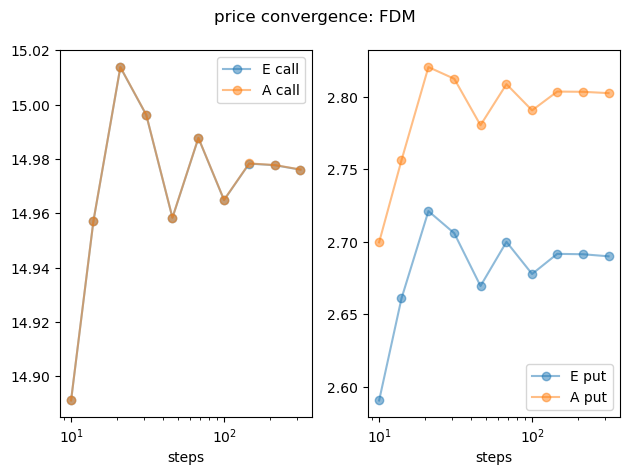

In [7]:
# calculate parameters
S0=100
K=90
r=0.06
sigma=0.2
div=0.03
T=1

Nsteps=np.logspace(1,2.5,10).astype(int) # steps sizes

Ecall_price_array=[]
Acall_price_array=[]
Eput_price_array=[]
Aput_price_array=[]

for nstep in Nsteps:
    #European
    price=FDM_Euro(S0=S0, K=K, r=r, sigma=sigma, div=div, T=T, Ntree=nstep, optype='call')
    Ecall_price_array.append(price[nstep,0])
    price=FDM_Euro(S0=S0, K=K, r=r, sigma=sigma, div=div, T=T, Ntree=nstep, optype='put')
    Eput_price_array.append(price[nstep,0])
    #American
    price=FDM_Amer(S0=S0, K=K, r=r, sigma=sigma, div=div, T=T, Ntree=nstep, optype='call')
    Acall_price_array.append(price[nstep,0])
    price=FDM_Amer(S0=S0, K=K, r=r, sigma=sigma, div=div, T=T, Ntree=nstep, optype='put')
    Aput_price_array.append(price[nstep,0])

fig,ax=plt.subplots(1,2)
ax[0].semilogx(Nsteps,Ecall_price_array, 'o-', alpha=0.5, label='E call')
ax[0].semilogx(Nsteps,Acall_price_array, 'o-', alpha=0.5, label='A call')
ax[0].set_xlabel('steps')
ax[0].legend()

ax[1].semilogx(Nsteps,Eput_price_array, 'o-', alpha=0.5, label='E put')
ax[1].semilogx(Nsteps,Aput_price_array, 'o-', alpha=0.5, label='A put')
ax[1].set_xlabel('steps')
ax[1].legend()

plt.suptitle('price convergence: FDM')
plt.tight_layout()